In [1]:
# Imports and setup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths & settings
TRAIN_DIR = './data/HAM10000_images/train_dir'
VAL_DIR = './data/HAM10000_images/val_dir'
MODEL_SAVE_PATH = './models/skin_lesion_model.keras'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

os.makedirs('./models', exist_ok=True)
os.makedirs('./plots', exist_ok=True)

# Classes
class_names = sorted(os.listdir(TRAIN_DIR))
print(f"Classes found: {class_names}")

Classes found: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [5]:
# Dataset structure visualization

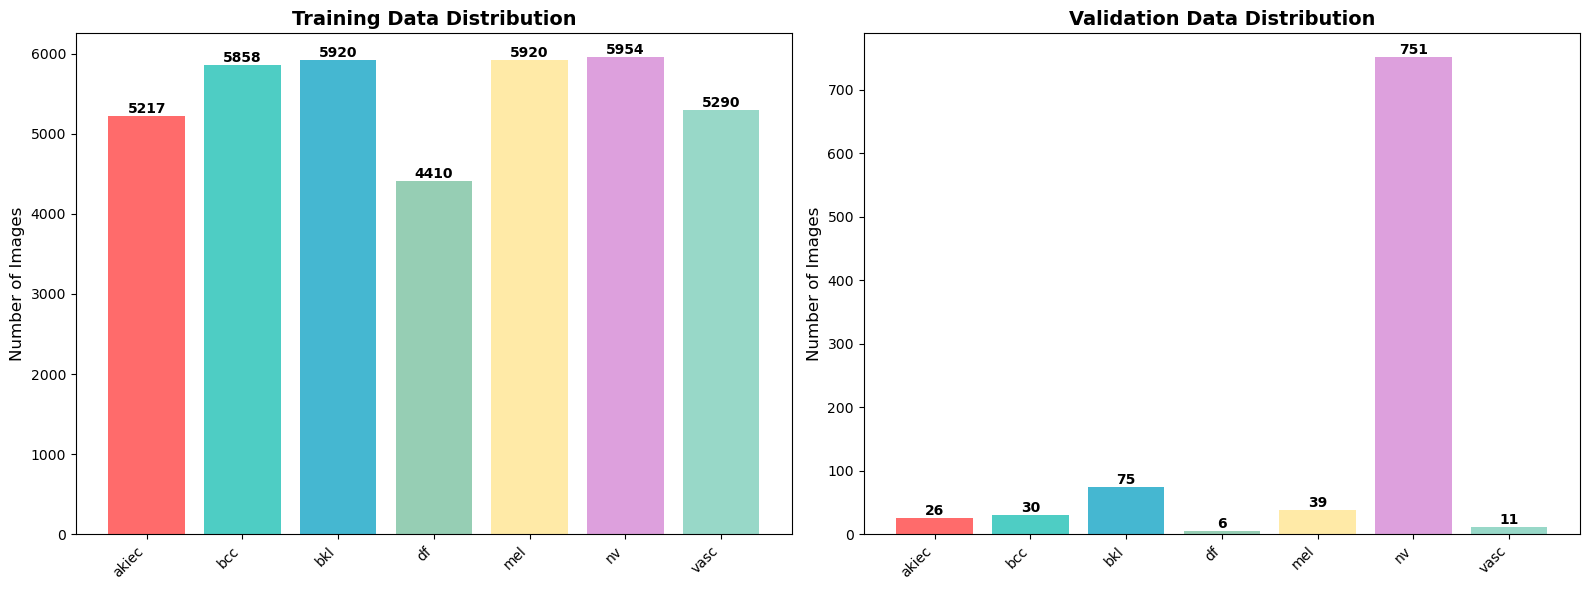

In [7]:
def analyze_dataset(train_dir, val_dir, class_names):
    train_counts = {c: len(os.listdir(os.path.join(train_dir, c))) for c in class_names}
    val_counts = {c: len(os.listdir(os.path.join(val_dir, c))) for c in class_names}

    # Plot distribution
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']

    # Training
    bars1 = ax1.bar(train_counts.keys(), train_counts.values(), color=colors)
    ax1.set_title('Training Data Distribution', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Images', fontsize=12)
    ax1.set_xticklabels(train_counts.keys(), rotation=45, ha='right')
    
    # Validation
    bars2 = ax2.bar(val_counts.keys(), val_counts.values(), color=colors)
    ax2.set_title('Validation Data Distribution', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Images', fontsize=12)
    ax2.set_xticklabels(val_counts.keys(), rotation=45, ha='right')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax = bar.axes
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('./plots/dataset_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return train_counts, val_counts

train_counts, val_counts = analyze_dataset(TRAIN_DIR, VAL_DIR, class_names)

In [9]:
# Sample images visualization

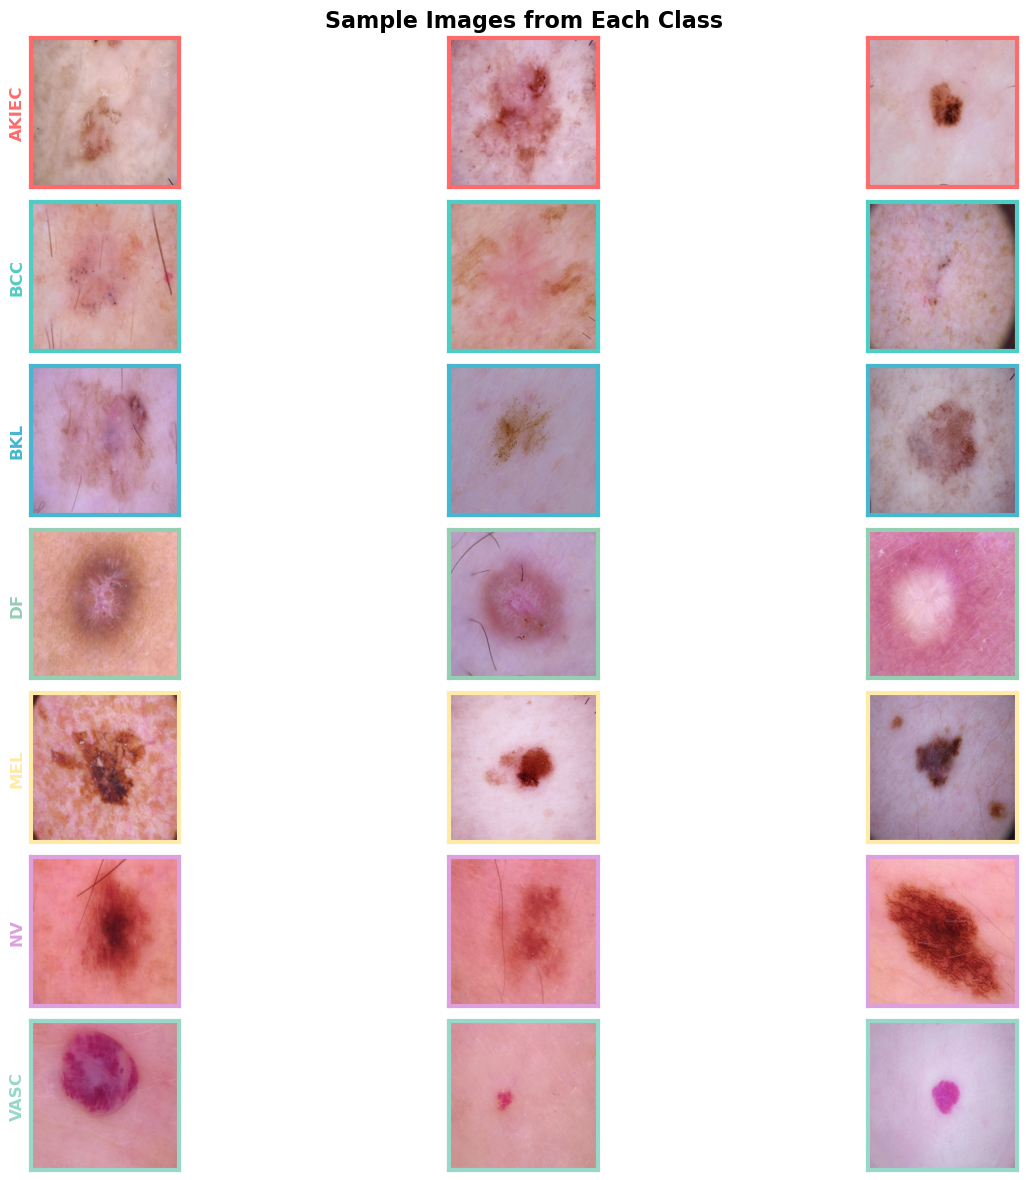

In [11]:
def display_sample_images(data_dir, class_names, num_samples=3):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(15, 12))
    fig.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:num_samples]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).resize(IMG_SIZE)
            axes[i, j].imshow(img)
            if j == 0:
                axes[i, j].set_ylabel(class_name.upper(), fontsize=12, fontweight='bold', color=colors[i])
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            for spine in axes[i, j].spines.values():
                spine.set_color(colors[i])
                spine.set_linewidth(3)
    plt.tight_layout()
    plt.savefig('./plots/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

display_sample_images(TRAIN_DIR, class_names)

In [13]:
# Create data generators

In [15]:
def create_generators(train_dir, val_dir, img_size, batch_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        brightness_range=[0.7,1.3],
        channel_shift_range=0.2
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )
    return train_gen, val_gen

train_gen, val_gen = create_generators(TRAIN_DIR, VAL_DIR, IMG_SIZE, BATCH_SIZE)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [17]:
# Compute Class Weights

In [19]:
all_labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = dict(zip(range(len(class_names)), class_weights))
print("Class weights:", class_weights)

Class weights: {0: 1.0561351625181412, 1: 0.9405696727308199, 2: 0.930719111969112, 3: 1.2494007126660187, 4: 0.930719111969112, 5: 0.925404290033111, 6: 1.0415608965703484}


In [21]:
# Model Definition

In [23]:
def create_model(num_classes=len(class_names), input_shape=(224,224,3)):
    input_layer = layers.Input(shape=input_shape)
    
    effnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in effnet.layers[:150]:
        layer.trainable = False
    effnet_features = layers.GlobalAveragePooling2D()(effnet.output)
    
    densenet = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
    for layer in densenet.layers[:150]:
        layer.trainable = False
    densenet_features = layers.GlobalAveragePooling2D()(densenet.output)
    
    x = layers.concatenate([effnet_features, densenet_features])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=input_layer, outputs=outputs)
    return model

model = create_model()
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 12,270,826 (46.81 MB)

 Trainable params: 9,924,703 (37.86 MB)

 Non-trainable params: 2,346,123 (8.95 MB)

In [25]:
# Training

In [27]:
steps_per_epoch = train_gen.samples // train_gen.batch_size
val_steps = val_gen.samples // val_gen.batch_size

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1),
    CSVLogger('./models/history.csv')
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    steps_per_epoch=200,
    validation_steps=val_steps,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3640 - loss: 1.7032
Epoch 1: val_accuracy improved from -inf to 0.83621, saving model to ./models/skin_lesion_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 901s 4s/step - accuracy: 0.3645 - loss: 1.7018 - val_accuracy: 0.8362 - val_loss: 0.4882 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6061 - loss: 1.0329
Epoch 2: val_accuracy improved from 0.83621 to 0.85129, saving model to ./models/skin_lesion_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.6061 - loss: 1.0329 - val_accuracy: 0.8513 - val_loss: 0.5350 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6508 - loss: 0.9321
Epoch 3: val_accuracy improved from 0.85129 to 0.87177, saving model to ./models/skin_lesion_model.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.6509 - loss: 0.9320 - val_accuracy: 0.8718 - val_loss: 0.4284 - learning_rate: 1.0000

In [52]:
# Training history visualization

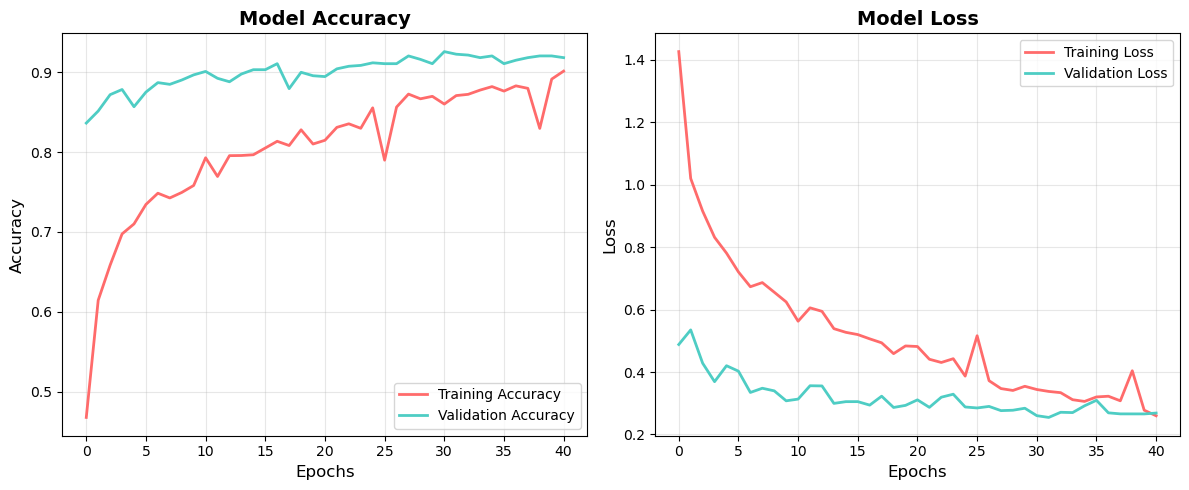

In [66]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#FF6B6B')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#4ECDC4')
plt.title('Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#FF6B6B')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#4ECDC4')
plt.title('Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
# Plot Training & Validation Loss

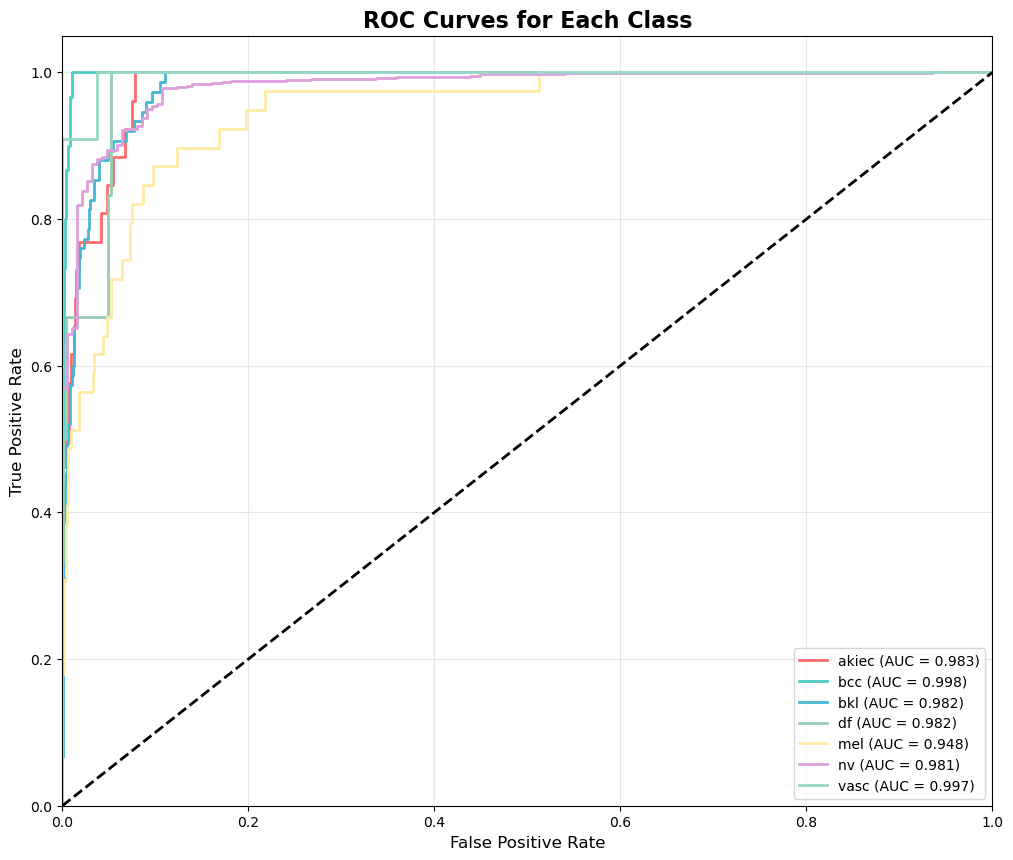

In [70]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ROC Curves
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8']

for i, class_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, 
             label=f'{class_name} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Each Class', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('./plots/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
# Always save final model at the end (even if not the best one)

In [74]:
FINAL_MODEL_PATH = './models/skin_lesion_model_final.keras'
model.save(FINAL_MODEL_PATH)
print(f"Final model saved to {FINAL_MODEL_PATH}")

Final model saved to ./models/skin_lesion_model_final.keras


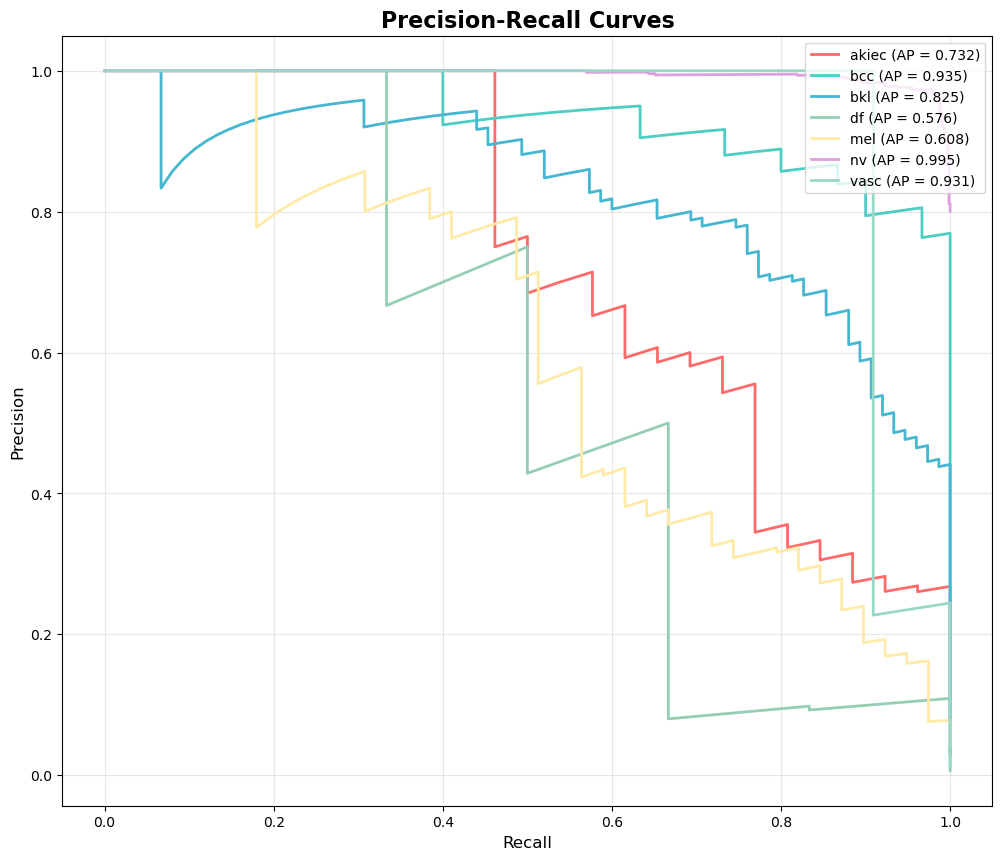

In [76]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curves
precision = {}
recall = {}
average_precision = {}

plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    precision[i], recall[i], _ = precision_recall_curve(y_true_binarized[:, i], y_pred[:, i])
    average_precision[i] = average_precision_score(y_true_binarized[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], color=colors[i], lw=2,
             label=f'{class_name} (AP = {average_precision[i]:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=16, fontweight='bold')
plt.legend(loc="upper right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig('./plots/precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# Extract metrics from classification report

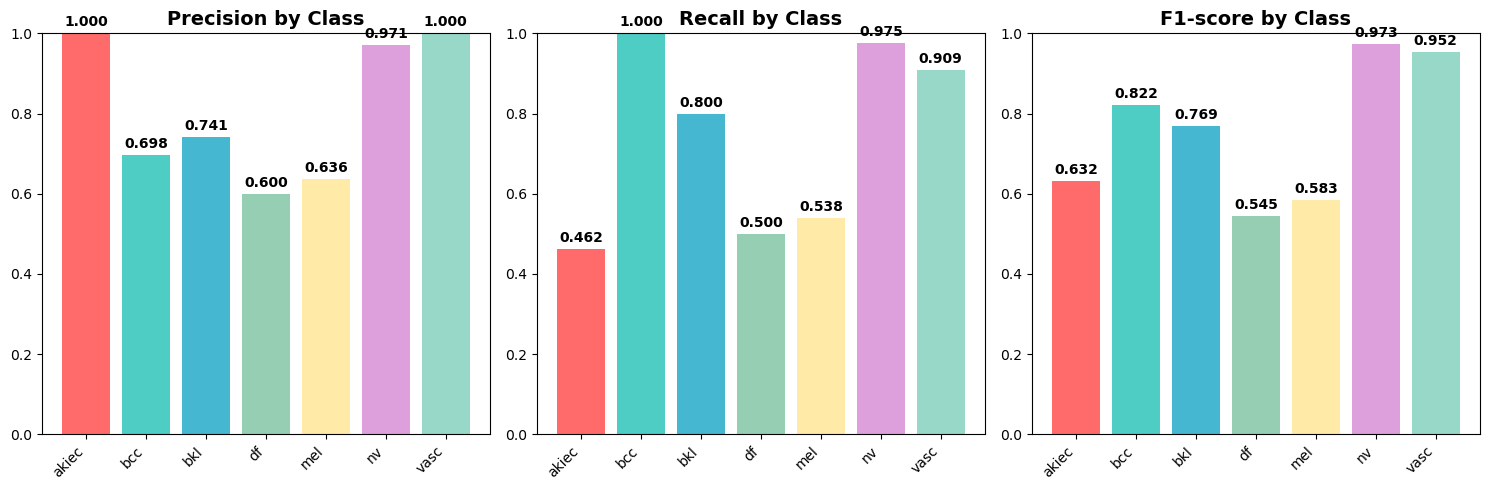

In [82]:
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Create performance comparison
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(15, 5))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    values = [report[class_name][metric] for class_name in class_names]
    bars = plt.bar(class_names, values, color=colors)
    plt.title(f'{metric.capitalize()} by Class', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/class_performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [84]:
# Evaluation

59/59 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step


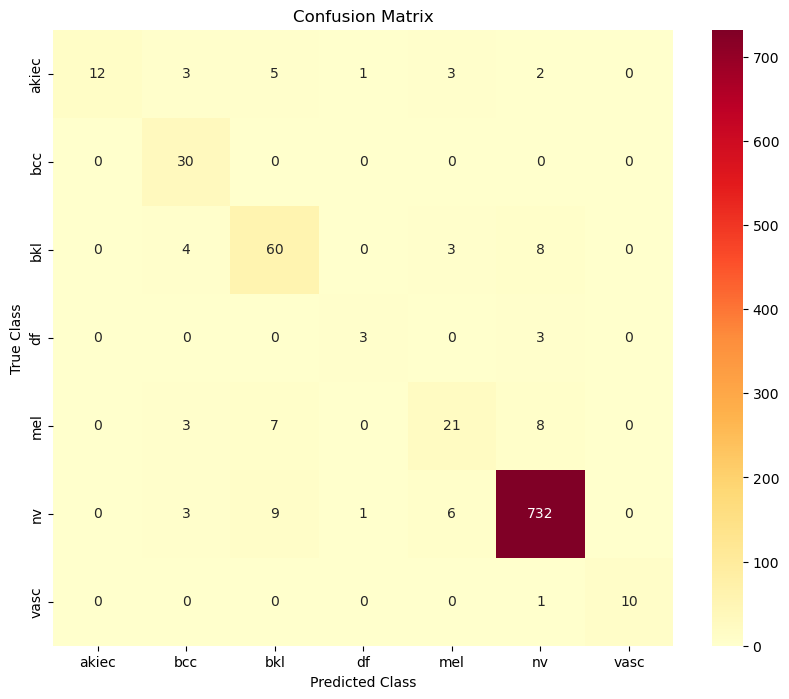

              precision    recall  f1-score   support

       akiec     1.0000    0.4615    0.6316        26
         bcc     0.6977    1.0000    0.8219        30
         bkl     0.7407    0.8000    0.7692        75
          df     0.6000    0.5000    0.5455         6
         mel     0.6364    0.5385    0.5833        39
          nv     0.9708    0.9747    0.9728       751
        vasc     1.0000    0.9091    0.9524        11

    accuracy                         0.9254       938
   macro avg     0.8065    0.7405    0.7538       938
weighted avg     0.9286    0.9254    0.9230       938



In [86]:
best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
val_gen.reset()
y_pred = best_model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='YlOrRd')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

In [87]:
# Prediction samples visualization

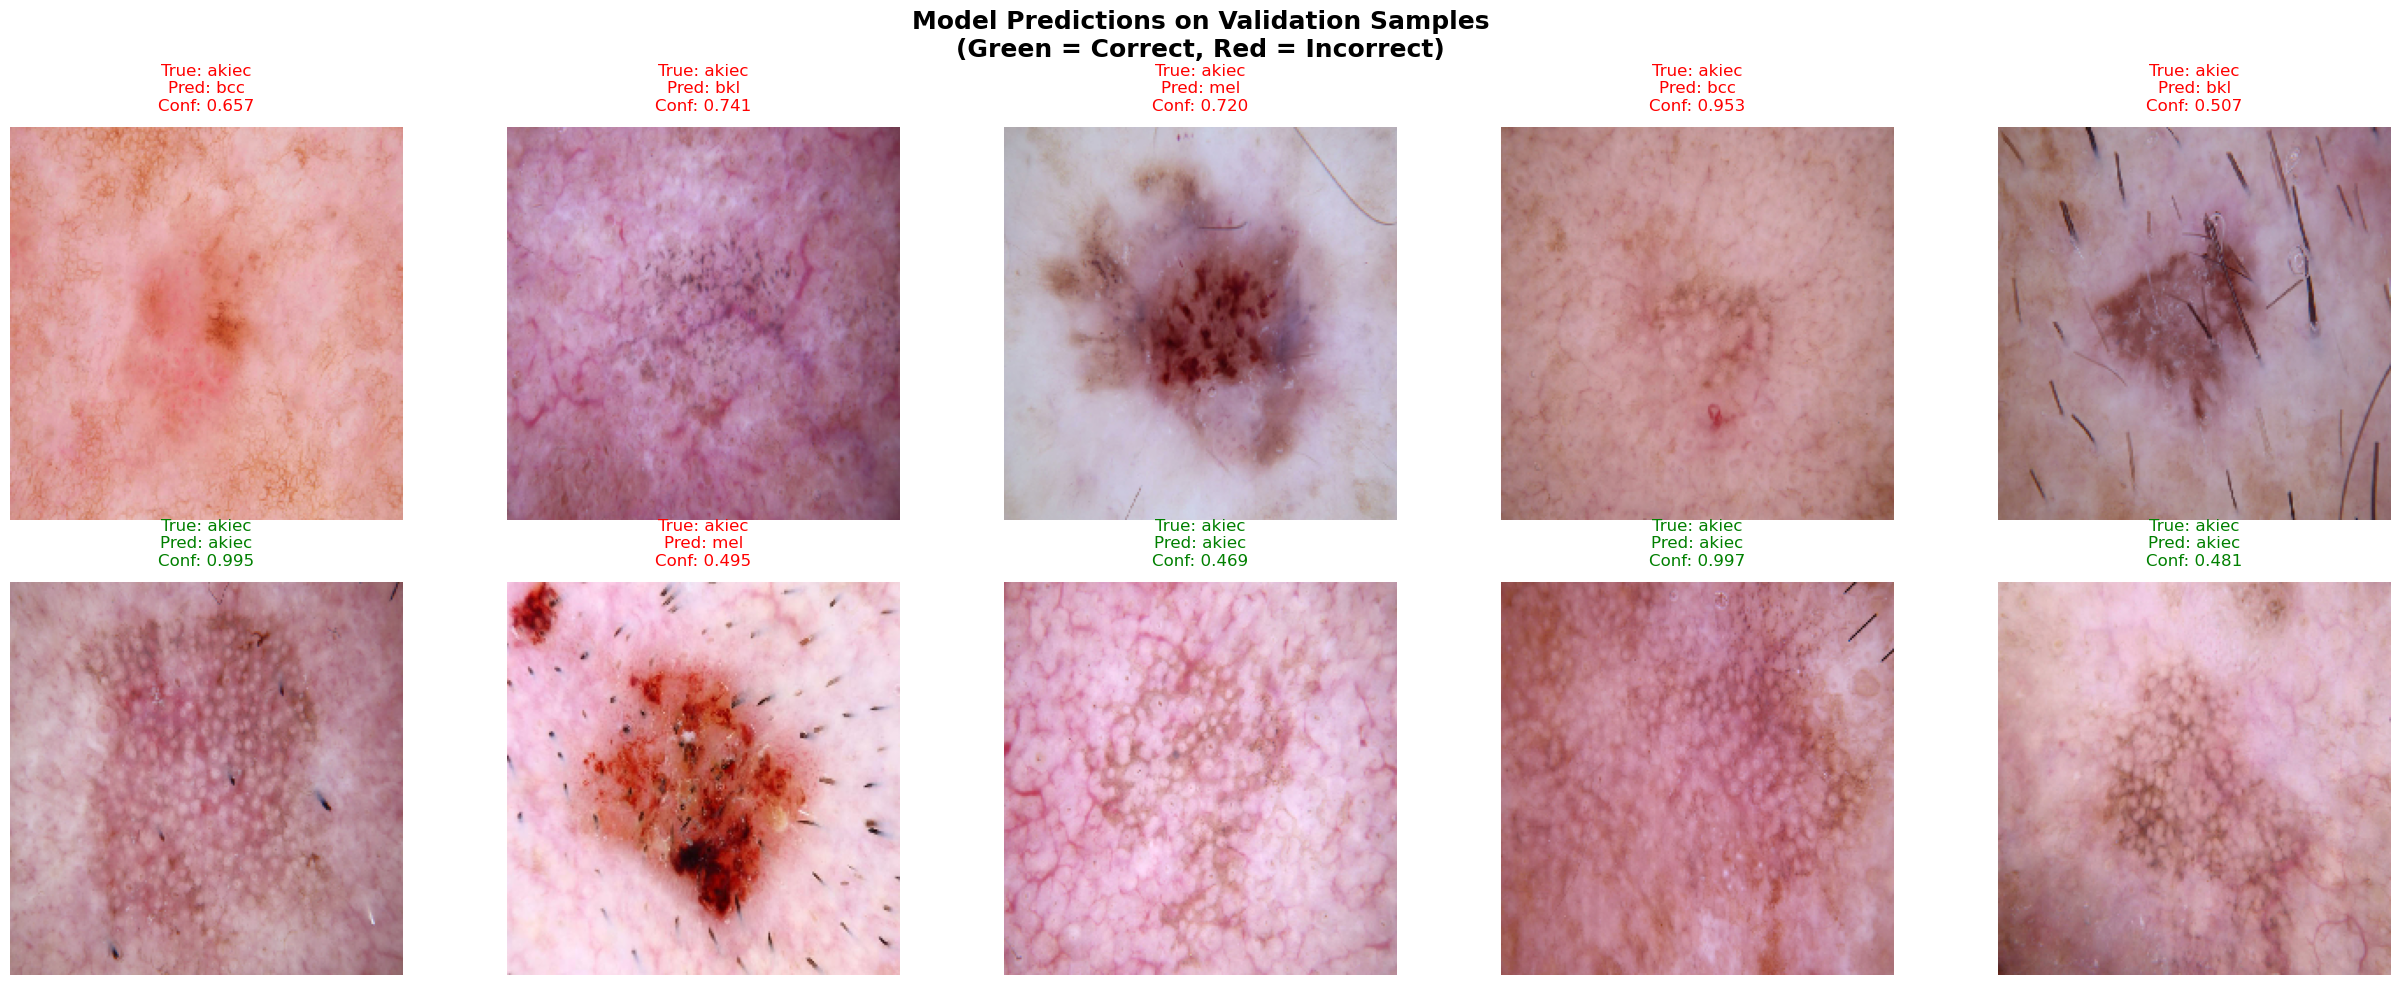

In [102]:
def visualize_predictions(model, generator, class_names, num_samples=10):
    generator.reset()
    x_batch, y_batch = next(generator)
    y_pred = model.predict(x_batch, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_batch, axis=1)
    
    # Create 2 rows with 5 columns each (for 10 samples)
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # Increased figure size
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(x_batch))):
        axes[i].imshow(x_batch[i])
        true_class = class_names[y_true_classes[i]]
        pred_class = class_names[y_pred_classes[i]]
        confidence = np.max(y_pred[i])
        
        color = 'green' if y_true_classes[i] == y_pred_classes[i] else 'red'
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}', 
                         color=color, fontsize=12, pad=12)  # Increased font size and padding
        axes[i].axis('off')
        
        for spine in axes[i].spines.values():
            spine.set_visible(True)
            spine.set_color('lightgray')
            spine.set_linewidth(2)
    
    plt.suptitle('Model Predictions on Validation Samples\n(Green = Correct, Red = Incorrect)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig('./plots/prediction_samples.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

# Call the function
visualize_predictions(best_model, val_gen, class_names)

In [89]:
# Final performance summary

In [90]:
print("="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
print(f"Overall Accuracy: {report['accuracy']:.3%}")
print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.3f}")
print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.3f}")
print("="*60)

print("\nTOP PERFORMING CLASSES:")
for class_name in class_names:
    if report[class_name]['f1-score'] > 0.8:
        print(f"✓ {class_name}: F1={report[class_name]['f1-score']:.3f}")

print("\nAREAS FOR IMPROVEMENT:")
for class_name in class_names:
    if report[class_name]['f1-score'] < 0.6:
        print(f"⚠ {class_name}: F1={report[class_name]['f1-score']:.3f}")

print("="*60)

FINAL PERFORMANCE SUMMARY
Overall Accuracy: 92.537%
Macro Avg F1-Score: 0.754
Weighted Avg F1-Score: 0.923

TOP PERFORMING CLASSES:
✓ bcc: F1=0.822
✓ nv: F1=0.973
✓ vasc: F1=0.952

AREAS FOR IMPROVEMENT:
⚠ df: F1=0.545
⚠ mel: F1=0.583
